In [1]:
%load_ext autoreload
%autoreload 

from preprocessing.preprocess_ucr import UCRDatasetImporter
from preprocessing.preprocess_ucr import UCRDataset
from preprocessing.preprocess_ucr import AugUCRDataset
from preprocessing.data_pipeline import build_data_pipeline
from utils import load_yaml_param_settings

from utils import time_to_timefreq, timefreq_to_time
from preprocessing.augmentations import TimeFreqAugmenter, Augmenter
import numpy as np
import torch
import matplotlib.pyplot as plt
from scipy.ndimage import rotate
import torch.nn.functional as F
import math

/home/erlendlokna/Documents/ntnu/Generative-SSL-VQVAE-modelling/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


self.X_train.shape: (1000, 128)
self.X_test.shape: (4000, 128)
# unique labels (train): [0 1 2 3]
# unique labels (test): [0 1 2 3]


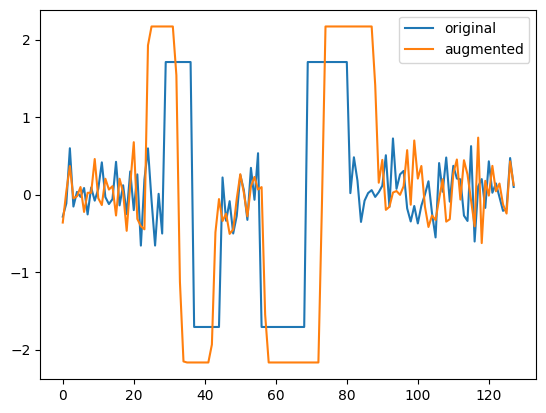

In [22]:
config = load_yaml_param_settings("configs/config.yaml")

dataset_name = "TwoPatterns"
config['dataset']['dataset_name'] = dataset_name

# data pipeline
dataset_importer = UCRDatasetImporter(**config["dataset"])
batch_size = config["dataset"]["batch_sizes"]["stage1"]
train_data_loader_aug = build_data_pipeline(
    batch_size, dataset_importer, config, "train", augment=True,
)
train_data_loader = build_data_pipeline(
    batch_size, dataset_importer, config, "train", augment=False
)

test_data_loader = build_data_pipeline(batch_size, dataset_importer, config, "test")

augmenter = TimeFreqAugmenter(**config["augmentations"]["aug_params"])
for batch in train_data_loader_aug:
    [x_original, xaug], y = batch
    break

plt.plot(x_original[0, 0], label="original")
plt.plot(xaug[0, 0], label="augmented")
plt.legend()
plt.savefig(dataset_name + "_augmentation.png")
plt.show()

In [27]:
from experiments.exp_vqvae import Exp_VQVAE
from utils import quantize
import torch.nn as nn
from einops import rearrange

input_length = train_data_loader.dataset.X.shape[-1]
input

config["SSL"]["stage1_method"] = ""
train_exp = Exp_VQVAE(
    input_length,
    config=config,
    n_train_samples=len(train_data_loader.dataset),
    train_data_loader=train_data_loader,
    test_data_loader=test_data_loader,
)
encoder = train_exp.encoder
vq_model = train_exp.vq_model

def encode_to_z_q(x, encoder, vq_model):
    """
    x: (B, C, L)
    """
    C = x.shape[1]
    xf = time_to_timefreq(x, 8, C)  # (B, C, H, W)
    z = encoder(xf)  # (b c h w)
    z_q, indices, vq_loss, perplexity = quantize(
        z, vq_model
    )  # (b c h w), (b (h w) h), ...
    return z_q, indices

In [17]:
# def generate_masks(emb, mask_emb, device="cpu", gamma=gamma_func()):
#     # randomly sample `t`
#     t = np.random.uniform(0, 1)

#     # create masks
#     n_masks = math.floor(gamma(t) * emb.shape[1])
#     rand = torch.rand(emb.shape, device=device)  # (b n)
#     mask = torch.zeros(emb.shape, dtype=torch.bool, device=device)
#     mask.scatter_(dim=1, index=rand.topk(n_masks, dim=1).indices, value=True)

#     # masked tokens
#     masked_indices = mask_emb * torch.ones_like(
#         emb, device=device
#     )  # (b n)
#     emb_M = mask * emb + (~mask) * masked_indices  # (b n); `~` reverses bool-typed data
#     return emb_M

def generate_masks(emb, mask_emb, device="cpu", gamma=gamma_func()):
    # randomly sample `t`
    t = np.random.uniform(0, 1)

    n_masks = math.floor(gamma(t) * emb.shape[1])
    print(n_masks)
    mask_indices = torch.rand(emb.shape[0], emb.shape[1], device=device).topk(n_masks, dim=1).indices
    
    mask = torch.zeros(emb.shape[0], emb.shape[1], dtype=torch.bool, device=device)
    mask.scatter_(1, mask_indices, True)

    # Apply masks
    emb_M = torch.where(mask.unsqueeze(-1), mask_emb, emb)  # use torch.where to select masked_emb or original

    return emb_M

mask_emb = nn.Parameter(torch.rand(dim, )) #(h, w, c)
zq, s = encode_to_z_q(x_original, encoder, vq_model) #zq has shape (b, c, h, w)
zq = rearrange(zq, "b c h w -> b (h w) c") #(b, h*w, c)
zq_M = generate_masks(zq, mask_emb) #returns shape with (b, h*w, c)



11


In [18]:
z_q, _ = encode_to_z_q(x_original, encoder, vq_model)  # (b n)

zq = rearrange(z_q, "b c h w -> b (h w) c")  # (b, h*w, c)

# randomly sample `t`
t = np.random.uniform(0, 1)
gamma = gamma_func("cosine")
n_masks = math.floor(gamma(t) * z_q.shape[1])

mask_indices = (
    torch.rand(z_q.shape[0], z_q.shape[1], device="cpu")
    .topk(n_masks, dim=1)
    .indices
)

mask = torch.zeros(z_q.shape[0], z_q.shape[1], dtype=torch.bool, device="cpu")
mask.scatter_(1, mask_indices, True)

# Apply masks
z_q_M = torch.where(mask.unsqueeze(-1), mask_emb, z_q)

RuntimeError: The size of tensor a (64) must match the size of tensor b (8) at non-singleton dimension 3

In [19]:
device = "cpu"

t = np.random.uniform(0, 1)

# create masks
n_masks = math.floor(gamma(t) * s.shape[1])
rand = torch.rand(s.shape, device=device)  # (b n)
mask = torch.zeros(s.shape, dtype=torch.bool, device=device)
mask.scatter_(dim=1, index=rand.topk(n_masks, dim=1).indices, value=True)

z_q, _ = encode_to_z_q(x_original, encoder, vq_model)  # (b n)
z_q = rearrange(z_q, "b c h w -> b (h w) c")  # (b, h*w, c)
mask_emb = nn.Parameter(torch.rand(dim, ))  # (c)

mask_emb = mask_emb.view(1, 1, -1)  # reshape to (1, 1, c)
z_q_M= torch.where(mask.unsqueeze(-1), mask_emb, z_q)  # apply the mask

In [20]:
print(n_masks)
print(torch.sum(z_q_M == mask_emb, dim=1))

29
tensor([[29, 29, 29,  ..., 29, 29, 29],
        [29, 29, 29,  ..., 29, 29, 29],
        [29, 29, 29,  ..., 29, 29, 29],
        ...,
        [29, 29, 29,  ..., 29, 29, 29],
        [29, 29, 29,  ..., 29, 29, 29],
        [29, 29, 29,  ..., 29, 29, 29]])


In [25]:
from experiments.exp_full_embed_maskgit import ExpFullEmbedMaskGIT
train_exp = ExpFullEmbedMaskGIT(
            input_length, config, len(train_data_loader.dataset), n_classes=len(np.unique(train_data_loader.dataset.Y))
)


/home/erlendlokna/Documents/ntnu/Generative-SSL-VQVAE-modelling/saved_models
vibcreg_encoder-TwoPatterns.ckpt
vibcreg encoder loaded
/home/erlendlokna/Documents/ntnu/Generative-SSL-VQVAE-modelling/saved_models
vibcreg_decoder-TwoPatterns.ckpt
vibcreg decoder loaded
/home/erlendlokna/Documents/ntnu/Generative-SSL-VQVAE-modelling/saved_models
vibcreg_vqmodel-TwoPatterns.ckpt
vibcreg vqmodel loaded


In [26]:
maskgit = train_exp.maskgit

